# Word Embedding (word2vec) Overview
:label:`sec_word2vec`


Natural language is a complex system used to express meanings.
In this system, words are the basic unit of the meaning.
As the name implies,
*word vectors* are vectors used to represent words,
and can also be considered as feature vectors or representations of words.
The technique of mapping words to real vectors
is called *word embedding*.
In recent years,
word embedding has gradually become
the basic knowledge of natural language processing.


## One-Hot Vectors Are a Bad Choice

We used one-hot vectors to represent words (characters are words) in :numref:`sec_rnn-scratch`.
Suppose that the number of different words in the dictionary (the dictionary size) is $N$,
and each word corresponds to
a different integer (index) from $0$ to $N-1$.
To obtain the one-hot vector representation
for any word with index $i$,
we create a length-$N$ vector with all 0s
and set the element at position $i$ to 1.
In this way, each word is represented as a vector of length $N$, and it
can be used directly by neural networks.


Although one-hot word vectors are easy to construct,
they are usually not a good choice.
A main reason is that one-hot word vectors cannot accurately express the similarity between different words, such as the *cosine similarity* that we often use.
For vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their cosine similarity is the cosine of the angle between them:


$$\frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1].$$


Since the cosine similarity between one-hot vectors of any two different words is 0,
one-hot vectors cannot encode similarities among words.


## Self-Supervised word2vec

The [word2vec](https://code.google.com/archive/p/word2vec/) tool was proposed to address the above issue.
It maps each word to a fixed-length vector, and  these vectors can better express the similarity and analogy relationship among different words.
The word2vec tool contains two models, namely *skip-gram* :cite:`Mikolov.Sutskever.Chen.ea.2013`  and *continuous bag of words* (CBOW) :cite:`Mikolov.Chen.Corrado.ea.2013`.
For semantically meaningful representations,
their training relies on
conditional probabilities
that can be viewed as predicting
some words using some of their surrounding words
in corpora.
Since supervision comes from the data without labels,
both skip-gram and continuous bag of words
are self-supervised models.

In the following, we will introduce these two models and their training methods.


## The Skip-Gram Model
:label:`subsec_skip-gram`

The *skip-gram* model assumes that a word can be used to generate its surrounding words in a text sequence.
Take the text sequence "the", "man", "loves", "his", "son" as an example.
Let's choose "loves" as the *center word* and set the context window size to 2.
As shown in :numref:`fig_skip_gram`,
given the center word "loves",
the skip-gram model considers
the conditional probability for generating the *context words*: "the", "man", "his", and "son",
which are no more than 2 words away from the center word:

$$P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).$$

Assume that
the context words are independently generated
given the center word (i.e., conditional independence).
In this case, the above conditional probability
can be rewritten as

$$P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$$

![The skip-gram model considers the conditional probability of generating the surrounding context words given a center word.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/skip-gram.svg?raw=1)
:label:`fig_skip_gram`

In the skip-gram model, each word
has two $d$-dimensional-vector representations
for calculating conditional probabilities.
More concretely,
for any word with index $i$ in the dictionary,
denote by $\mathbf{v}_i\in\mathbb{R}^d$
and $\mathbf{u}_i\in\mathbb{R}^d$
its two vectors
when used as a *center* word and a *context* word, respectively.
The conditional probability of generating any
context word $w_o$ (with index $o$ in the dictionary) given the center word $w_c$ (with index $c$ in the dictionary) can be modeled by
a softmax operation on vector dot products:


$$P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)},$$
:eqlabel:`eq_skip-gram-softmax`

where the vocabulary index set $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$.
Given a text sequence of length $T$, where the word at time step $t$ is denoted as $w^{(t)}$.
Assume that
context words are independently generated
given any center word.
For context window size $m$,
the likelihood function of the skip-gram model
is the probability of generating all context words
given any center word:


$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

where any time step that is less than $1$ or greater than $T$ can be omitted.

### Training

The skip-gram model parameters are the center word vector and context word vector for each word in the vocabulary.
In training, we learn the model parameters by maximizing the likelihood function (i.e., maximum likelihood estimation). This is equivalent to minimizing the following loss function:

$$ - \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \textrm{log}\, P(w^{(t+j)} \mid w^{(t)}).$$

When using stochastic gradient descent to minimize the loss,
in each iteration
we can
randomly sample a shorter subsequence to calculate the (stochastic) gradient for this subsequence to update the model parameters.
To calculate this (stochastic) gradient,
we need to obtain
the gradients of
the log conditional probability with respect to the center word vector and the context word vector.
In general, according to :eqref:`eq_skip-gram-softmax`
the log conditional probability
involving any pair of the center word $w_c$ and
the context word $w_o$ is


$$\log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$
:eqlabel:`eq_skip-gram-log`

Through differentiation, we can obtain its gradient
with respect to the center word vector $\mathbf{v}_c$ as

$$\begin{aligned}\frac{\partial \textrm{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.\end{aligned}$$
:eqlabel:`eq_skip-gram-grad`


Note that the calculation in :eqref:`eq_skip-gram-grad` requires the conditional probabilities of all words in the dictionary with $w_c$ as the center word.
The gradients for the other word vectors can be obtained in the same way.


After training, for any word with index $i$ in the dictionary, we obtain both word vectors
$\mathbf{v}_i$ (as the center word) and $\mathbf{u}_i$ (as the context word).
In natural language processing applications, the center word vectors of the skip-gram model are typically
used as the word representations.


## The Continuous Bag of Words (CBOW) Model


The *continuous bag of words* (CBOW) model is similar to the skip-gram model.
The major difference
from the skip-gram model is that
the continuous bag of words model
assumes that a center word is generated
based on its surrounding context words in the text sequence.
For example,
in the same text sequence "the", "man", "loves", "his", and "son", with "loves" as the center word and the context window size being 2,
the continuous bag of words model
considers
the conditional probability of generating the center word "loves" based on the context words "the", "man", "his" and "son" (as shown in :numref:`fig_cbow`), which is

$$P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).$$

![The continuous bag of words model considers the conditional probability of generating the center word given its surrounding context words.](http://d2l.ai/_images/cbow.svg)
:label:`fig_cbow`


Since there are multiple context words
in the continuous bag of words model,
these context word vectors are averaged
in the calculation of the conditional probability.
Specifically,
for any word with index $i$ in the dictionary,
denote by $\mathbf{v}_i\in\mathbb{R}^d$
and $\mathbf{u}_i\in\mathbb{R}^d$
its two vectors
when used as a *context* word and a *center* word
(meanings are switched in the skip-gram model), respectively.
The conditional probability of generating any
center word $w_c$ (with index $c$ in the dictionary) given its surrounding context words $w_{o_1}, \ldots, w_{o_{2m}}$ (with index $o_1, \ldots, o_{2m}$ in the dictionary) can be modeled by



$$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\exp\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \exp\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}.$$
:eqlabel:`fig_cbow-full`


For brevity, let $\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$ and $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}} \right)/(2m)$. Then :eqref:`fig_cbow-full` can be simplified as

$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$

Given a text sequence of length $T$, where the word at time step $t$ is denoted as $w^{(t)}$.
For context window size $m$,
the likelihood function of the continuous bag of words model
is the probability of generating all center words
given their context words:


$$ \prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

### Training

Training continuous bag of words models
is almost the same as
training skip-gram models.
The maximum likelihood estimation of the
continuous bag of words model is equivalent to minimizing the following loss function:



$$  -\sum_{t=1}^T  \textrm{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

Notice that

$$\log\,P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log\,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).$$

Through differentiation, we can obtain its gradient
with respect to any context word vector $\mathbf{v}_{o_i}$($i = 1, \ldots, 2m$)
as


$$\frac{\partial \log\, P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} = \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) = \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).$$
:eqlabel:`eq_cbow-gradient`


The gradients for the other word vectors can be obtained in the same way.
Unlike the skip-gram model,
the continuous bag of words model
typically
uses context word vectors as the word representations.




## Summary

* Word vectors are vectors used to represent words, and can also be considered as feature vectors or representations of words. The technique of mapping words to real vectors is called word embedding.
* The word2vec tool contains both the skip-gram  and continuous bag of words models.
* The skip-gram model assumes that a word can be used to generate its surrounding words in a text sequence; while the continuous bag of words model assumes that a center word is generated based on its surrounding context words.



## Exercises

1. What is the computational complexity for calculating each gradient? What could be the issue if the dictionary size is huge?
1. Some fixed phrases in English consist of multiple words, such as "new york". How to train their word vectors? Hint: see Section 4 in the word2vec paper :cite:`Mikolov.Sutskever.Chen.ea.2013`.
1. Let's reflect on the word2vec design by taking the skip-gram model as an example. What is the relationship between the dot product of two word vectors in the skip-gram model and the cosine similarity? For a pair of words with similar semantics, why may the cosine similarity of their word vectors (trained by the skip-gram model) be high?

# Implementation

In [ ]:
%pip install gensim      # For Word2Vec models and phrase detection
%pip install matplotlib  # For plotting and visualizations
%pip install numpy       # For numerical operations
%pip install torch       # For PyTorch (manual implementations)
%pip install pandas      # For data handling

## Using module torch.nn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- 1. NGỮ CẢNH (CORPUS) ---
# Một đoạn văn bản đơn giản lặp lại các concept về giới tính và hoàng gia
corpus = [
    "king is a man",
    "queen is a woman",
    "prince is a boy",
    "princess is a girl",
    "king and queen",
    "prince and princess",
    "man and woman",
    "boy and girl"
]

# Tạo bộ từ điển (Vocabulary)
tokens = [sent.split() for sent in corpus]
vocabulary = set([word for sent in tokens for word in sent])
word2idx = {w: i for i, w in enumerate(vocabulary)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(vocabulary)
print(f"Tổng số từ vựng: {vocab_size}")
print(f"Từ điển: {word2idx}")

# Hyperparameters
embedding_dim = 2  # Chỉ dùng 2 chiều để vẽ trục X, Y trực tiếp (không cần giảm chiều)
window_size = 1    # Lấy 1 từ bên trái và 1 từ bên phải
lr = 0.01
epochs = 1000

# --- 2. TẠO DỮ LIỆU TRAINING ---

# Hàm tạo data cho Skip-Gram: Input (Giữa) -> Output (Xung quanh)
def generate_skipgram_data(tokens, window):
    data = []
    for sentence in tokens:
        for i, target in enumerate(sentence):
            # Lấy các từ ngữ cảnh trong cửa sổ
            for j in range(max(0, i - window), min(len(sentence), i + window + 1)):
                if i != j:
                    context = sentence[j]
                    data.append((word2idx[target], word2idx[context]))
    return data

# Hàm tạo data cho CBOW: Input (Xung quanh) -> Output (Giữa)
def generate_cbow_data(tokens, window):
    data = []
    for sentence in tokens:
        for i, target in enumerate(sentence):
            context_idxs = []
            # Lấy context trái và phải
            for j in range(max(0, i - window), min(len(sentence), i + window + 1)):
                if i != j:
                    context_idxs.append(word2idx[sentence[j]])
            # Chỉ lấy nếu có context (tránh từ đơn lẻ)
            if len(context_idxs) > 0:
                data.append((context_idxs, word2idx[target]))
    return data

skipgram_data = generate_skipgram_data(tokens, window_size)
cbow_data = generate_cbow_data(tokens, window_size)

print(f"\nVí dụ dữ liệu Skip-Gram (Target -> Context): {skipgram_data[:3]}")
print(f"Ví dụ dữ liệu CBOW (Contexts -> Target): {cbow_data[:3]}")

Tổng số từ vựng: 11
Từ điển: {'queen': 0, 'princess': 1, 'man': 2, 'and': 3, 'boy': 4, 'woman': 5, 'is': 6, 'girl': 7, 'king': 8, 'prince': 9, 'a': 10}

Ví dụ dữ liệu Skip-Gram (Target -> Context): [(8, 6), (6, 8), (6, 10)]
Ví dụ dữ liệu CBOW (Contexts -> Target): [([6], 8), ([8, 10], 6), ([6, 2], 10)]


In [ ]:
# --- MODEL SKIP-GRAM ---
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(SkipGram, self).__init__()
        self.center_embeddings = nn.Linear(vocab_size, emb_dim, bias=False) # Input -> Hidden
        self.context_embeddings = nn.Linear(emb_dim, vocab_size, bias=False) # Hidden -> Output

    def forward(self, target_idx):
        # Chuyển index thành one-hot vector (giả lập) để nhân ma trận
        x = torch.zeros(vocab_size)
        x[target_idx] = 1.0

        # Forward pass
        hidden = self.center_embeddings(x)
        output = self.context_embeddings(hidden)
        return output

# --- MODEL CBOW ---
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(CBOW, self).__init__()
        self.context_embeddings = nn.Linear(vocab_size, emb_dim, bias=False) # Input -> Hidden
        self.center_embeddings = nn.Linear(emb_dim, vocab_size, bias=False)  # Hidden -> Output

    def forward(self, context_idxs):
        # Tạo vector tổng hợp cho context
        x_sum = torch.zeros(vocab_size)
        for idx in context_idxs:
            x_temp = torch.zeros(vocab_size)
            x_temp[idx] = 1.0
            x_sum += x_temp # Cộng dồn các one-hot của context

        # Tính trung bình (Mean)
        x_mean = x_sum / len(context_idxs)

        # Forward pass
        hidden = self.context_embeddings(x_mean)
        output = self.center_embeddings(hidden)
        return output

# --- TRAINING FUNCTION ---
def train_model(model, data, model_type="SkipGram"):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    print(f"--- Đang train {model_type}... ---")
    for epoch in range(epochs):
        total_loss = 0
        for item in data:
            optimizer.zero_grad()

            if model_type == "SkipGram":
                target, context = item
                pred = model(target) # Output là xác suất các từ context
                loss = loss_fn(pred.unsqueeze(0), torch.tensor([context]))

            elif model_type == "CBOW":
                contexts, target = item
                pred = model(contexts) # Output là xác suất từ center
                loss = loss_fn(pred.unsqueeze(0), torch.tensor([target]))

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch+1) % 200 == 0:
            print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

    return model

# Khởi tạo và Train
model_sg = SkipGram(vocab_size, embedding_dim)
model_sg = train_model(model_sg, skipgram_data, "SkipGram")

model_cbow = CBOW(vocab_size, embedding_dim)
model_cbow = train_model(model_cbow, cbow_data, "CBOW")

--- Đang train SkipGram... ---
Epoch 200: Loss = 52.1435
Epoch 400: Loss = 51.2103
Epoch 600: Loss = 51.1264
Epoch 800: Loss = 51.1066
Epoch 1000: Loss = 51.0992
--- Đang train CBOW... ---
Epoch 200: Loss = 42.1501
Epoch 400: Loss = 30.7945
Epoch 600: Loss = 29.1980
Epoch 800: Loss = 28.7847
Epoch 1000: Loss = 28.6158



--- KẾT QUẢ ---


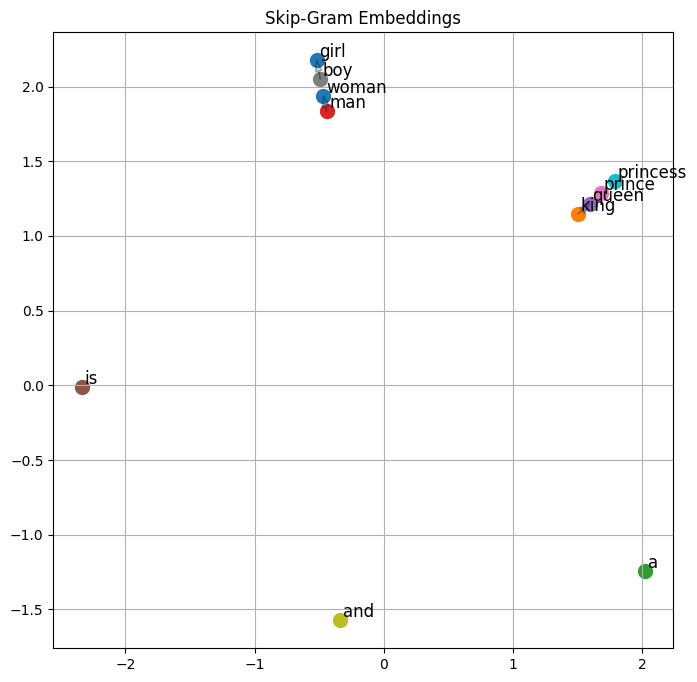

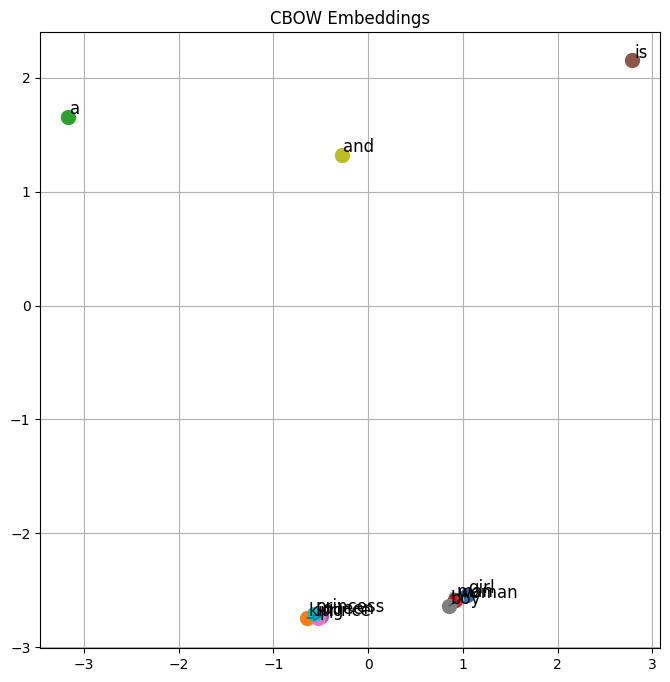

In [ ]:
def plot_embeddings(model, title):
    # Lấy weights từ lớp Linear đầu tiên (Input -> Hidden)
    # Đây chính là vector đại diện cho từ
    if title == "Skip-Gram Embeddings":
        weights = model.center_embeddings.weight.data.T.numpy() # Transpose để có shape [vocab, 2]
    else:
        weights = model.context_embeddings.weight.data.T.numpy()

    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.grid(True)

    # Vẽ điểm
    for i in range(vocab_size):
        x, y = weights[i][0], weights[i][1]
        word = idx2word[i]
        plt.scatter(x, y, s=100)
        plt.text(x + 0.02, y + 0.02, word, fontsize=12)

    # Vẽ đường nối để thể hiện quan hệ (nếu các từ gần nhau)
    # Ví dụ nối King -> Queen, Man -> Woman
    def draw_arrow(w1, w2):
        if w1 in word2idx and w2 in word2idx:
            i1, i2 = word2idx[w1], word2idx[w2]
            plt.arrow(weights[i1][0], weights[i1][1],
                      weights[i2][0]-weights[i1][0], weights[i2][1]-weights[i1][1],
                      head_width=0.05, length_includes_head=True, alpha=0.3)

    draw_arrow("king", "queen")
    draw_arrow("man", "woman")
    draw_arrow("boy", "girl")

    plt.show()

# Hiển thị biểu đồ
print("\n--- KẾT QUẢ ---")
plot_embeddings(model_sg, "Skip-Gram Embeddings")
plot_embeddings(model_cbow, "CBOW Embeddings")

###UseCase

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 69.8 MB/s eta 0:00:00


In [ ]:
from gensim.models import Word2Vec
import pandas as pd

# Giả lập lịch sử mua hàng (Mỗi dòng là một giỏ hàng/session của 1 user)
# Thay vì câu văn "Tôi học AI", ta có "Laptop Chuột Bàn_phím"
transactions = [
    ['iPhone', 'Ốp_lưng', 'Sạc_nhanh', 'Tai_nghe_AirPods'], # User 1: Fan Apple
    ['Samsung_S24', 'Ốp_lưng', 'Sạc_nhanh', 'Tai_nghe_GalaxyBuds'], # User 2: Fan Samsung
    ['Laptop_Dell', 'Chuột_Logitech', 'Bàn_phím_Cơ', 'Lót_chuột', 'Màn_hình_LG'], # User 3: Setup PC
    ['Laptop_Macbook', 'Chuột_MagicMouse', 'Hub_TypeC', 'Túi_chống_sốc'], # User 4: Setup Mac
    ['iPhone', 'Sạc_nhanh', 'Cường_lực'], # User 5
    ['Samsung_S24', 'Sạc_nhanh', 'Cường_lực'], # User 6
    ['Laptop_Dell', 'Chuột_Logitech', 'Balo_Laptop'], # User 7
    ['Bàn_phím_Cơ', 'Chuột_Logitech', 'Lót_chuột'], # User 8
    ['iPhone', 'Tai_nghe_AirPods', 'Apple_Watch'], # User 9: Hệ sinh thái Apple
    ['Samsung_S24', 'Tai_nghe_GalaxyBuds', 'Galaxy_Watch'] # User 10: Hệ sinh thái Samsung
]

# Nhân bản dữ liệu lên để model học tốt hơn (Trong thực tế bạn có hàng triệu dòng)
transactions = transactions * 100

In [ ]:
# --- MODEL 1: CBOW ---
# Ý nghĩa: Dựa vào ngữ cảnh cả giỏ hàng để tìm sản phẩm phù hợp ở giữa.
# Tốt cho việc tìm sản phẩm thay thế hoặc phổ biến chung.
model_cbow = Word2Vec(
    sentences=transactions,
    vector_size=10, # Số chiều vector (nhỏ vì ít sản phẩm)
    window=3,       # Độ rộng ngữ cảnh
    min_count=1,    # Bỏ qua sản phẩm xuất hiện ít hơn 1 lần
    sg=0,           # 0 = CBOW
    epochs=50,
    seed=42
)

# --- MODEL 2: SKIP-GRAM ---
# Ý nghĩa: Dựa vào 1 sản phẩm để tìm các sản phẩm lân cận.
# Tốt cho việc tìm sản phẩm hay đi kèm (phụ kiện) và dữ liệu hiếm.
model_skipgram = Word2Vec(
    sentences=transactions,
    vector_size=10,
    window=3,
    min_count=1,
    sg=1,           # 1 = Skip-Gram
    epochs=50,
    seed=42
)

print("Đã train xong 2 models!")

Đã train xong 2 models!


In [ ]:
def recommend_products(model, product_name, model_name):
    try:
        # Tìm các vector gần nhất (Cosine Similarity)
        similar_products = model.wv.most_similar(product_name, topn=3)
        print(f"\n--- {model_name} gợi ý cho '{product_name}' ---")
        for prod, score in similar_products:
            print(f"  - {prod} (Độ tương đồng: {score:.4f})")
    except KeyError:
        print(f"Sản phẩm {product_name} không có trong dữ liệu.")

# --- CASE 1: Mua iPhone thì gợi ý gì? ---
recommend_products(model_cbow, 'iPhone', 'CBOW')
recommend_products(model_skipgram, 'iPhone', 'Skip-Gram')

# --- CASE 2: Mua Chuột Logitech thì gợi ý gì? ---
recommend_products(model_skipgram, 'Chuột_Logitech', 'Skip-Gram')

# --- CASE 3: So sánh tương đồng (Đố vui toán học) ---
# Logic: Laptop_Dell - Chuột_Logitech + Chuột_MagicMouse = ???
# (Dùng Dell xài chuột Logitech, vậy dùng Mac xài chuột gì?)
try:
    result = model_skipgram.wv.most_similar(positive=['Laptop_Macbook', 'Chuột_Logitech'], negative=['Laptop_Dell'], topn=1)
    print(f"\n--- Logic suy luận (Skip-Gram) ---")
    print(f"Laptop_Dell đi với Chuột_Logitech, thì Laptop_Macbook đi với: {result[0][0]}")
except:
    pass


--- CBOW gợi ý cho 'iPhone' ---
  - Apple_Watch (Độ tương đồng: 0.9238)
  - Ốp_lưng (Độ tương đồng: 0.9133)
  - Tai_nghe_AirPods (Độ tương đồng: 0.8853)

--- Skip-Gram gợi ý cho 'iPhone' ---
  - Ốp_lưng (Độ tương đồng: 0.9336)
  - Apple_Watch (Độ tương đồng: 0.9161)
  - Tai_nghe_AirPods (Độ tương đồng: 0.8834)

--- Skip-Gram gợi ý cho 'Chuột_Logitech' ---
  - Laptop_Dell (Độ tương đồng: 0.9448)
  - Màn_hình_LG (Độ tương đồng: 0.9448)
  - Lót_chuột (Độ tương đồng: 0.9445)

--- Logic suy luận (Skip-Gram) ---
Laptop_Dell đi với Chuột_Logitech, thì Laptop_Macbook đi với: Túi_chống_sốc


##Manual Computation

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DATASET ---
corpus = [
    "king is a man",
    "queen is a woman",
    "prince is a boy",
    "princess is a girl",
    "king and queen",
    "prince and princess",
    "man and woman",
    "boy and girl"
]

# Tạo từ điển
tokens = [sent.split() for sent in corpus]
vocabulary = set([word for sent in tokens for word in sent])
word2idx = {w: i for i, w in enumerate(vocabulary)}
idx2word = {i: w for w, i in word2idx.items()}
V = len(vocabulary)

print(f"Vocab size: {V}")
print(f"Word mapping: {word2idx}")

# Hyperparameters
d = 2       # Embedding dimension (2 chiều để vẽ luôn)
lr = 0.1    # Learning rate
epochs = 2000 # Train lâu một chút để tách cụm rõ

# Tạo training data
window = 1

# Data cho Skip-Gram: [Target] -> [Context]
skipgram_data = []
for sent in tokens:
    for i, target in enumerate(sent):
        for j in range(max(0, i-window), min(len(sent), i+window+1)):
            if i != j:
                skipgram_data.append((word2idx[target], word2idx[sent[j]]))

# Data cho CBOW: [Contexts] -> [Target]
cbow_data = []
for sent in tokens:
    for i, target in enumerate(sent):
        context_idxs = []
        for j in range(max(0, i-window), min(len(sent), i+window+1)):
            if i != j:
                context_idxs.append(word2idx[sent[j]])
        if context_idxs:
            cbow_data.append((context_idxs, word2idx[target]))

Vocab size: 11
Word mapping: {'woman': 0, 'king': 1, 'a': 2, 'man': 3, 'queen': 4, 'is': 5, 'prince': 6, 'boy': 7, 'and': 8, 'princess': 9, 'girl': 10}


In [ ]:
print("\n--- TRAINING SKIP-GRAM (MANUAL) ---")

# 1. Khởi tạo trọng số (Random)
# require_grad=True để PyTorch tự tính đạo hàm giúp (không cần viết công thức đạo hàm tay dài dòng)
W1 = torch.randn(V, d, requires_grad=True) # Center Vectors
W2 = torch.randn(d, V, requires_grad=True) # Context Vectors

loss_history_sg = []

for epoch in range(epochs):
    total_loss = 0

    for target_idx, context_idx in skipgram_data:
        # --- FORWARD PASS (TÍNH TAY) ---

        # Bước 1: Lấy vector của từ target (Lookup Table)
        # Tương đương nhân one-hot với W1: h = W1[target_idx]
        h = W1[target_idx] # Shape: [d]

        # Bước 2: Tính Score (Dot Product với toàn bộ từ trong vocab)
        # z = W2_transposed * h (nhưng ở đây W2 shape [d, V] nên nhân trực tiếp)
        # z = h . W2 -> Shape: [V]
        z = torch.matmul(h, W2)

        # Bước 3: Softmax thủ công
        # y_hat = exp(z) / sum(exp(z))
        y_hat = F.softmax(z, dim=0)

        # --- LOSS CALCULATION ---
        # Cross Entropy Loss = -log(y_hat[context_true])
        loss = -torch.log(y_hat[context_idx])
        total_loss += loss.item()

        # --- BACKWARD PASS (GRADIENT) ---
        loss.backward() # Tự động tính gradient dL/dW1 và dL/dW2

        # --- UPDATE WEIGHTS (SGD THỦ CÔNG) ---
        with torch.no_grad():
            # W = W - lr * gradient
            W1 -= lr * W1.grad
            W2 -= lr * W2.grad

            # Reset gradient về 0 cho vòng lặp sau
            W1.grad.zero_()
            W2.grad.zero_()

    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# Lưu lại embedding kết quả để vẽ
sg_embeddings = W1.detach().numpy()


--- TRAINING SKIP-GRAM (MANUAL) ---
Epoch 500: Loss = 58.7819
Epoch 1000: Loss = 58.8423
Epoch 1500: Loss = 58.8509
Epoch 2000: Loss = 58.8531


In [ ]:
print("\n--- TRAINING CBOW (MANUAL) ---")

# 1. Khởi tạo lại trọng số mới
W1_cbow = torch.randn(V, d, requires_grad=True) # Context Matrix (Input)
W2_cbow = torch.randn(d, V, requires_grad=True) # Center Matrix (Output)

for epoch in range(epochs):
    total_loss = 0

    for context_idxs, target_idx in cbow_data:
        # --- FORWARD PASS (TÍNH TAY) ---

        # Bước 1: Lấy các vector context
        # contexts_vecs shape: [num_context, d]
        context_vecs = W1_cbow[context_idxs]

        # Bước 2: TÍNH TRUNG BÌNH (Đặc trưng của CBOW)
        # h = mean(context_vecs)
        h = torch.mean(context_vecs, dim=0) # Shape: [d]

        # Bước 3: Tính Score (Dot product với output matrix)
        z = torch.matmul(h, W2_cbow) # Shape: [V]

        # Bước 4: Softmax
        y_hat = F.softmax(z, dim=0)

        # --- LOSS ---
        loss = -torch.log(y_hat[target_idx])
        total_loss += loss.item()

        # --- BACKWARD ---
        loss.backward()

        # --- UPDATE ---
        with torch.no_grad():
            W1_cbow -= lr * W1_cbow.grad
            W2_cbow -= lr * W2_cbow.grad

            W1_cbow.grad.zero_()
            W2_cbow.grad.zero_()

    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# Lưu kết quả
cbow_embeddings = W1_cbow.detach().numpy()


--- TRAINING CBOW (MANUAL) ---
Epoch 500: Loss = 30.4132
Epoch 1000: Loss = 30.1920
Epoch 1500: Loss = 30.0735
Epoch 2000: Loss = 29.9960


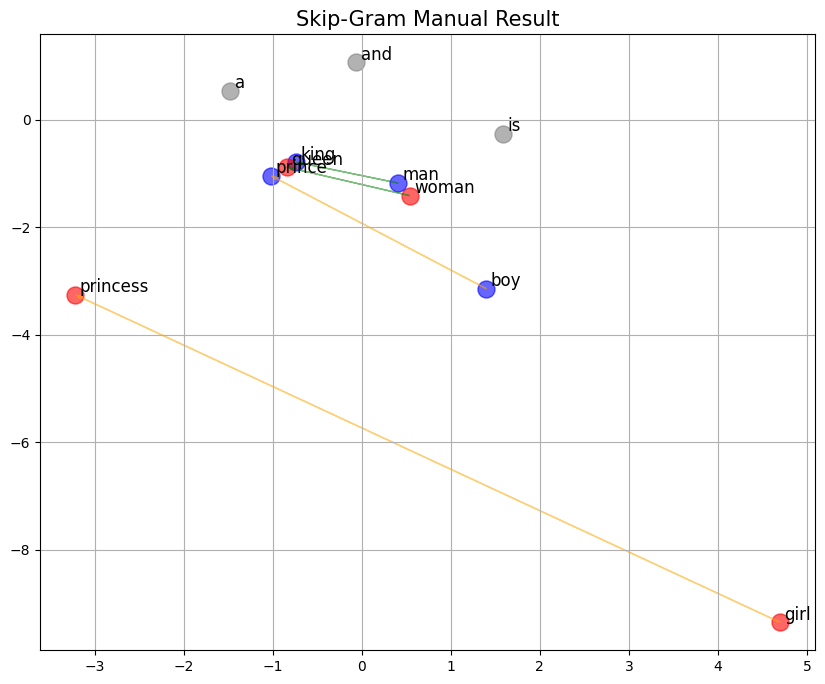

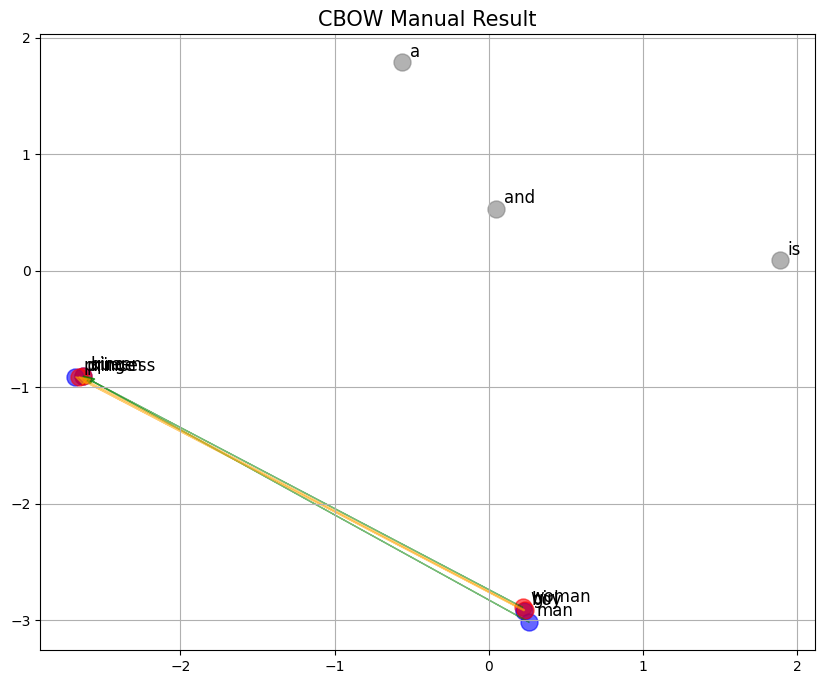

In [ ]:
def plot_manual_embeddings(weights, title):
    plt.figure(figsize=(10, 8))
    plt.title(title, fontsize=15)
    plt.grid(True)

    # Vẽ các điểm
    for i in range(V):
        x, y = weights[i][0], weights[i][1]
        word = idx2word[i]

        # Tô màu khác nhau cho giới tính để dễ nhìn
        color = 'blue'
        if word in ['queen', 'woman', 'girl', 'princess']:
            color = 'red'
        elif word in ['king', 'man', 'boy', 'prince']:
            color = 'blue'
        else:
            color = 'gray' # từ nối

        plt.scatter(x, y, c=color, s=150, alpha=0.6)
        plt.text(x+0.05, y+0.05, word, fontsize=12)

    # Vẽ mũi tên quan hệ: Man -> King, Woman -> Queen
    # Nếu mô hình học tốt, 2 mũi tên này sẽ song song và cùng chiều dài
    def draw_arrow(w1, w2, c='green'):
        if w1 in word2idx and w2 in word2idx:
            i1, i2 = word2idx[w1], word2idx[w2]
            plt.arrow(weights[i1][0], weights[i1][1],
                      weights[i2][0]-weights[i1][0], weights[i2][1]-weights[i1][1],
                      head_width=0.05, length_includes_head=True, color=c, alpha=0.5)

    draw_arrow("man", "king")
    draw_arrow("woman", "queen")

    # Thêm cặp khác: Boy -> Prince, Girl -> Princess
    draw_arrow("boy", "prince", c='orange')
    draw_arrow("girl", "princess", c='orange')

    plt.show()

# Vẽ đồ thị
plot_manual_embeddings(sg_embeddings, "Skip-Gram Manual Result")
plot_manual_embeddings(cbow_embeddings, "CBOW Manual Result")

###Usecase

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- DỮ LIỆU GIẢ LẬP (Hóa đơn mua hàng) ---
transactions = [
    ['iPhone', 'Ốp_lưng', 'Sạc_nhanh', 'AirPods'],
    ['Samsung', 'Ốp_lưng', 'Sạc_nhanh', 'GalaxyBuds'],
    ['Laptop_Dell', 'Chuột', 'Bàn_phím', 'Lót_chuột'],
    ['Macbook', 'Chuột', 'Hub_USB', 'Túi_chống_sốc'],
    ['iPhone', 'Sạc_nhanh', 'Cường_lực'],
    ['Samsung', 'Sạc_nhanh', 'Cường_lực'],
    ['Laptop_Dell', 'Chuột', 'Balo'],
    ['Bàn_phím', 'Chuột', 'Lót_chuột'],
    ['iPhone', 'AirPods', 'Apple_Watch']
]

# 1. Tạo từ điển (Vocabulary)
products = sorted(list(set([item for sublist in transactions for item in sublist])))
prod2idx = {p: i for i, p in enumerate(products)}
idx2prod = {i: p for p, i in prod2idx.items()}
vocab_size = len(products)

print(f"Danh sách sản phẩm ({vocab_size} món): {products}")

# 2. Tạo Training Data thủ công
# Chúng ta sẽ làm Skip-Gram: Input (1 món) -> Dự đoán các món còn lại trong cùng đơn
# Window size = 2 (Lấy 2 món bên trái, 2 món bên phải)
window_size = 2
training_data = []

for bill in transactions:
    indices = [prod2idx[p] for p in bill]
    for i, target_idx in enumerate(indices):
        # Lấy các món xung quanh trong window
        start = max(0, i - window_size)
        end = min(len(indices), i + window_size + 1)

        for j in range(start, end):
            if i != j: # Không lấy chính nó
                context_idx = indices[j]
                training_data.append((target_idx, context_idx))

print(f"\nSố lượng cặp training: {len(training_data)}")
print(f"Ví dụ 5 cặp đầu tiên (Target -> Context): {training_data[:5]}")
# Ví dụ: Mua iPhone (index X) -> Có khả năng mua Ốp lưng (index Y)

Danh sách sản phẩm (16 món): ['AirPods', 'Apple_Watch', 'Balo', 'Bàn_phím', 'Chuột', 'Cường_lực', 'GalaxyBuds', 'Hub_USB', 'Laptop_Dell', 'Lót_chuột', 'Macbook', 'Samsung', 'Sạc_nhanh', 'Túi_chống_sốc', 'iPhone', 'Ốp_lưng']

Số lượng cặp training: 70
Ví dụ 5 cặp đầu tiên (Target -> Context): [(14, 15), (14, 12), (15, 14), (15, 12), (15, 0)]


In [ ]:
# --- CẤU HÌNH ---
embedding_dim = 4  # Mỗi sản phẩm được biểu diễn bằng vector 4 chiều
learning_rate = 0.05
epochs = 1000

# --- MODEL SKIP-GRAM THỦ CÔNG ---
class ManualSkipGram(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(ManualSkipGram, self).__init__()
        # Input -> Hidden: Đây chính là ma trận vector của sản phẩm
        # bias=False để đúng với công thức toán học W.x
        self.W1 = nn.Linear(vocab_size, emb_dim, bias=False)

        # Hidden -> Output: Ma trận ngữ cảnh
        self.W2 = nn.Linear(emb_dim, vocab_size, bias=False)

    def forward(self, target_idx):
        # 1. Tạo one-hot vector cho đầu vào thủ công
        x_one_hot = torch.zeros(vocab_size)
        x_one_hot[target_idx] = 1.0

        # 2. Tính toán lớp ẩn (Lấy hàng tương ứng của W1)
        # h = W1.T * x
        hidden = self.W1(x_one_hot)

        # 3. Tính toán đầu ra (Score cho tất cả sản phẩm context)
        # z = W2 * h
        score = self.W2(hidden)

        # 4. Không cần Softmax ở đây vì CrossEntropyLoss của PyTorch đã bao gồm Softmax
        return score

# Khởi tạo model
model = ManualSkipGram(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# --- TRAINING LOOP ---
print("\n--- BẮT ĐẦU TRAINING ---")
for epoch in range(epochs):
    total_loss = 0
    for target, context in training_data:

        # 1. Zero grad
        optimizer.zero_grad()

        # 2. Forward
        pred_scores = model(target) # Output: vector độ dài [vocab_size]

        # 3. Loss (So sánh vector dự đoán với index thực tế của context)
        loss = criterion(pred_scores.unsqueeze(0), torch.tensor([context]))

        # 4. Backward
        loss.backward()

        # 5. Update weights
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(training_data):.4f}")

print("Training hoàn tất!")


--- BẮT ĐẦU TRAINING ---
Epoch 200: Loss = 1.5502
Epoch 400: Loss = 1.5386
Epoch 600: Loss = 1.5330
Epoch 800: Loss = 1.5292
Epoch 1000: Loss = 1.5263
Training hoàn tất!


In [ ]:
# Lấy ma trận Embedding ra (đã train xong)
# W1 có shape [emb_dim, vocab_size] do cách PyTorch lưu Linear, nên ta cần Transpose
# Tuy nhiên ở trên ta định nghĩa Linear(vocab, emb), nên weight có shape [emb, vocab].
# Ta cần lấy Transpose để có shape [vocab, emb] -> Mỗi hàng là 1 sản phẩm.
final_embeddings = model.W1.weight.data.T

# --- HÀM TÍNH TOÁN ĐỘ TƯƠNG ĐỒNG (THỦ CÔNG) ---
def get_cosine_similarity(vec_a, vec_b):
    # 1. Tích vô hướng (Dot product)
    dot_product = torch.dot(vec_a, vec_b)

    # 2. Độ dài vector (Norm) = căn bậc hai của tổng bình phương
    norm_a = torch.norm(vec_a)
    norm_b = torch.norm(vec_b)

    # 3. Cosine
    return dot_product / (norm_a * norm_b)

def recommend_manual(product_name, k=3):
    if product_name not in prod2idx:
        print("Sản phẩm không tồn tại!")
        return

    target_id = prod2idx[product_name]
    target_vec = final_embeddings[target_id]

    print(f"\n--- Đang tìm sản phẩm giống '{product_name}'... ---")
    print(f"Vector đặc trưng (đã học): {target_vec.numpy()}")

    similarities = []

    # Duyệt qua tất cả sản phẩm khác để tính khoảng cách
    for i in range(vocab_size):
        if i == target_id: continue # Bỏ qua chính nó

        other_vec = final_embeddings[i]
        score = get_cosine_similarity(target_vec, other_vec)

        similarities.append((idx2prod[i], score.item()))

    # Sắp xếp giảm dần theo điểm score
    similarities.sort(key=lambda x: x[1], reverse=True)

    # In kết quả top K
    for item, score in similarities[:k]:
        print(f"  > Gợi ý: {item} | Độ tương đồng: {score:.4f}")

# --- KIỂM TRA KẾT QUẢ ---
# Case 1: Mua iPhone (Kỳ vọng: Ốp lưng, Sạc nhanh, AirPods...)
recommend_manual('iPhone')

# Case 2: Mua Chuột (Kỳ vọng: Bàn phím, Lót chuột, Laptop...)
recommend_manual('Chuột')

# Case 3: Mua Laptop_Dell (Kỳ vọng: Chuột, Balo...)
recommend_manual('Laptop_Dell')


--- Đang tìm sản phẩm giống 'iPhone'... ---
Vector đặc trưng (đã học): [-0.42423773  1.104623    1.0103507  -0.01696407]
  > Gợi ý: Samsung | Độ tương đồng: 0.9178
  > Gợi ý: GalaxyBuds | Độ tương đồng: 0.6569
  > Gợi ý: Bàn_phím | Độ tương đồng: 0.3566

--- Đang tìm sản phẩm giống 'Chuột'... ---
Vector đặc trưng (đã học): [-0.05440662  0.9294625  -0.5109966  -0.99724704]
  > Gợi ý: Cường_lực | Độ tương đồng: 0.3732
  > Gợi ý: Ốp_lưng | Độ tương đồng: 0.2787
  > Gợi ý: Balo | Độ tương đồng: 0.2544

--- Đang tìm sản phẩm giống 'Laptop_Dell'... ---
Vector đặc trưng (đã học): [-1.1470968  -1.8891379  -1.1324849   0.23432276]
  > Gợi ý: Lót_chuột | Độ tương đồng: 0.8270
  > Gợi ý: AirPods | Độ tương đồng: 0.4898
  > Gợi ý: Hub_USB | Độ tương đồng: 0.4448


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- 1. DỮ LIỆU & TỪ ĐIỂN (GIỮ NGUYÊN) ---
transactions = [
    ['iPhone', 'Ốp_lưng', 'Sạc_nhanh', 'AirPods'],
    ['Samsung', 'Ốp_lưng', 'Sạc_nhanh', 'GalaxyBuds'],
    ['Laptop_Dell', 'Chuột', 'Bàn_phím', 'Lót_chuột'],
    ['Macbook', 'Chuột', 'Hub_USB', 'Túi_chống_sốc'],
    ['iPhone', 'Sạc_nhanh', 'Cường_lực'],
    ['Samsung', 'Sạc_nhanh', 'Cường_lực'],
    ['Laptop_Dell', 'Chuột', 'Balo'],
    ['Bàn_phím', 'Chuột', 'Lót_chuột'],
    ['iPhone', 'AirPods', 'Apple_Watch']
]

products = sorted(list(set([item for sublist in transactions for item in sublist])))
prod2idx = {p: i for i, p in enumerate(products)}
idx2prod = {i: p for p, i in prod2idx.items()}
vocab_size = len(products)
embedding_dim = 4

# --- 2. TẠO TRAINING DATA CHO CBOW ---
# Input: [Context_1, Context_2, ...] -> Output: Target
window_size = 2
cbow_train_data = []

for bill in transactions:
    indices = [prod2idx[p] for p in bill]
    for i, target_idx in enumerate(indices):
        context_idxs = []
        # Quét cửa sổ trái phải
        start = max(0, i - window_size)
        end = min(len(indices), i + window_size + 1)

        for j in range(start, end):
            if i != j: # Khác vị trí target
                context_idxs.append(indices[j])

        # Chỉ train nếu có context (tránh giỏ hàng chỉ có 1 món)
        if len(context_idxs) > 0:
            cbow_train_data.append((context_idxs, target_idx))

print(f"Số mẫu training CBOW: {len(cbow_train_data)}")
# Ví dụ: Context là [iPhone, Sạc_nhanh] -> Target là Ốp_lưng
print(f"Ví dụ mẫu đầu tiên: Context IDs {cbow_train_data[0][0]} -> Target ID {cbow_train_data[0][1]}")

Số mẫu training CBOW: 31
Ví dụ mẫu đầu tiên: Context IDs [15, 12] -> Target ID 14


In [ ]:
class ManualCBOW(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(ManualCBOW, self).__init__()
        # W1: Ma trận Input -> Hidden (Embedding)
        self.W1 = nn.Linear(vocab_size, emb_dim, bias=False)
        # W2: Ma trận Hidden -> Output
        self.W2 = nn.Linear(emb_dim, vocab_size, bias=False)

    def forward(self, context_indices):
        # 1. TẠO VECTOR ĐẦU VÀO TỔNG HỢP (MANUAL MEAN)
        # Thay vì đưa vào 1 one-hot, ta tạo vector đại diện cho cả ngữ cảnh
        x_context_mean = torch.zeros(vocab_size)

        for idx in context_indices:
            x_one_hot = torch.zeros(vocab_size)
            x_one_hot[idx] = 1.0
            x_context_mean += x_one_hot # Cộng dồn

        # Chia trung bình (Mean)
        x_context_mean = x_context_mean / len(context_indices)

        # 2. Hidden Layer (Projection)
        # h = W1.T * x_mean
        hidden = self.W1(x_context_mean)

        # 3. Output Layer (Score)
        score = self.W2(hidden)

        return score

# Khởi tạo
model_cbow = ManualCBOW(vocab_size, embedding_dim)
optimizer = optim.SGD(model_cbow.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss() # Đã bao gồm Softmax

# --- 3. TRAINING LOOP ---
print("\n--- BẮT ĐẦU TRAIN CBOW ---")
for epoch in range(1000):
    total_loss = 0
    for contexts, target in cbow_train_data:
        optimizer.zero_grad()

        # Forward pass (Truyền list các index ngữ cảnh vào)
        pred_scores = model_cbow(contexts)

        # Loss
        loss = criterion(pred_scores.unsqueeze(0), torch.tensor([target]))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(cbow_train_data):.4f}")


--- BẮT ĐẦU TRAIN CBOW ---
Epoch 200: Loss = 0.4520
Epoch 400: Loss = 0.3921
Epoch 600: Loss = 0.3793
Epoch 800: Loss = 0.3727
Epoch 1000: Loss = 0.3684


In [ ]:
# Lấy trọng số đã học
# Transpose lại vì nn.Linear lưu shape [out, in]
final_embeddings_cbow = model_cbow.W1.weight.data.T

# Hàm tính Cosine (Dùng lại hàm cũ)
def get_cosine_similarity(vec_a, vec_b):
    return torch.dot(vec_a, vec_b) / (torch.norm(vec_a) * torch.norm(vec_b))

def recommend_cbow(product_name):
    if product_name not in prod2idx: return
    target_id = prod2idx[product_name]
    target_vec = final_embeddings_cbow[target_id]

    similarities = []
    for i in range(vocab_size):
        if i == target_id: continue
        other_vec = final_embeddings_cbow[i]
        score = get_cosine_similarity(target_vec, other_vec)
        similarities.append((idx2prod[i], score.item()))

    similarities.sort(key=lambda x: x[1], reverse=True)
    print(f"\n[CBOW] Gợi ý cho '{product_name}':")
    for item, score in similarities[:3]:
        print(f"  - {item}: {score:.4f}")

# --- TEST KẾT QUẢ ---
# 1. iPhone -> Kỳ vọng: Ốp lưng, Sạc nhanh...
recommend_cbow('iPhone')

# 2. Laptop_Dell -> Kỳ vọng: Chuột, Balo...
recommend_cbow('Laptop_Dell')


[CBOW] Gợi ý cho 'iPhone':
  - Samsung: 0.9858
  - Ốp_lưng: 0.4130
  - GalaxyBuds: 0.3751

[CBOW] Gợi ý cho 'Laptop_Dell':
  - Túi_chống_sốc: 0.6279
  - Macbook: 0.6067
  - Lót_chuột: 0.5536


# EXERCISES SOLUTIONS

Below are detailed solutions to the three exercises from the theoretical section.

## Exercise 1: Computational Complexity and Dictionary Size Issues

**Question:** What is the computational complexity for calculating each gradient? What could be the issue if the dictionary size is huge?

### Answer:

#### Computational Complexity Analysis:

Looking at the gradient formula for skip-gram (equation from the theory section):

$$\frac{\partial \log P(w_o \mid w_c)}{\partial \mathbf{v}_c} = \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j$$

**For Skip-Gram:**
- To compute the gradient for ONE center-context pair, we need to:
  1. Calculate the softmax denominator: $\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)$
  2. This requires computing dot products for ALL vocabulary words: $|\mathcal{V}|$ dot products
  3. Each dot product is $O(d)$ where $d$ is embedding dimension
  4. Computing the weighted sum: $\sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j$ requires $|\mathcal{V}|$ operations

**Total complexity per gradient: $O(|\mathcal{V}| \cdot d)$**

**For CBOW:** Similar analysis gives the same complexity: $O(|\mathcal{V}| \cdot d)$

#### Issues with Huge Dictionary:

1. **Computational Bottleneck:**
   - If $|\mathcal{V}| = 100,000$ words (typical), we need 100K operations per training example
   - Training on millions of sentences becomes prohibitively slow
   - GPU memory may not fit all embeddings

2. **Memory Requirements:**
   - Need to store TWO embedding matrices: $W_1$ and $W_2$, each of size $|\mathcal{V}| \times d$
   - Total parameters: $2 \times |\mathcal{V}| \times d$
   - Example: 100K vocab, 300 dims = 60 million parameters = 240MB (float32)

3. **Softmax Denominator Problem:**
   - Computing softmax over entire vocabulary is the main bottleneck
   - Must sum over all $|\mathcal{V}|$ words for EVERY training example

#### Solutions Used in Practice:

1. **Negative Sampling:**
   - Instead of computing softmax over entire vocab, sample K negative examples (typically K=5-20)
   - Complexity reduces from $O(|\mathcal{V}|)$ to $O(K)$
   - This is what gensim's Word2Vec uses by default

2. **Hierarchical Softmax:**
   - Organize vocabulary as a binary tree (Huffman tree)
   - Reduces complexity from $O(|\mathcal{V}|)$ to $O(\log |\mathcal{V}|)$
   - Each word only needs to traverse path from root to leaf

3. **Subsampling Frequent Words:**
   - Downweight common words like "the", "a", "is"
   - Reduces training examples while preserving quality

## Exercise 2: Training Word Vectors for Multi-Word Phrases

**Question:** Some fixed phrases in English consist of multiple words, such as "new york". How to train their word vectors?

### Answer:

Multi-word phrases (also called n-grams or collocations) like "New York", "machine learning", or "ice cream" should be treated as single tokens because:
- Their meaning is NOT compositional (New York ≠ "new" + "york")
- They represent distinct semantic concepts

#### Solution Approach (from word2vec paper Section 4):

**1. Phrase Detection Using Statistical Scoring:**

The paper proposes using a **scoring function** to identify phrases:

$$\text{score}(w_i, w_j) = \frac{\text{count}(w_i w_j) - \delta}{\text{count}(w_i) \times \text{count}(w_j)}$$

Where:
- $\text{count}(w_i w_j)$ = number of times words $w_i$ and $w_j$ appear together
- $\text{count}(w_i)$ = frequency of word $w_i$ alone
- $\delta$ = discounting coefficient (prevents rare words forming phrases)

**High score** means the words appear together much more than expected by chance → likely a phrase

**2. Training Process:**

1. **First Pass - Phrase Detection:**
   - Scan corpus and compute scores for all adjacent word pairs
   - If score > threshold, merge into single token
   - Example: "New" + "York" → "New_York"

2. **Second Pass - Optional:**
   - Repeat phrase detection on the transformed corpus
   - Can find longer phrases: "New_York" + "City" → "New_York_City"

3. **Final Pass - Train Word2Vec:**
   - Train skip-gram or CBOW on the corpus with phrases treated as single words
   - "New_York" gets its own embedding vector

#### Example Implementation:

In [ ]:
# Example: Phrase detection and training with gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

# Sample corpus with multi-word phrases
sentences = [
    ['new', 'york', 'is', 'a', 'city'],
    ['new', 'york', 'city', 'is', 'large'],
    ['i', 'love', 'new', 'york'],
    ['machine', 'learning', 'is', 'fun'],
    ['i', 'study', 'machine', 'learning'],
    ['deep', 'learning', 'uses', 'neural', 'networks'],
    ['ice', 'cream', 'is', 'cold'],
    ['i', 'eat', 'ice', 'cream']
]

print("=== BEFORE PHRASE DETECTION ===")
print("Sample sentence:", sentences[0])
print()

# STEP 1: Train phrase detector (bigrams)
# min_count=2: phrase must appear at least 2 times
# threshold=1: lower threshold = more phrases detected (default is 10)
phrase_model = Phrases(sentences, min_count=2, threshold=1)

# Apply phrase detection to transform corpus
sentences_with_phrases = [phrase_model[sent] for sent in sentences]

print("=== AFTER PHRASE DETECTION (First Pass) ===")
for i, sent in enumerate(sentences_with_phrases[:5]):
    print(f"Sentence {i+1}: {sent}")
print()

# MANUAL COMPUTATION OF PHRASE DETECTON
# from collections import Counter

# def compute_phrase_score(bigram_counts, unigram_counts, delta=5):
#     """
#     Compute phrase scores with custom delta

#     Args:
#         bigram_counts: Counter of ('word1', 'word2') -> count
#         unigram_counts: Counter of 'word' -> count
#         delta: Discounting coefficient (default 5)
#     """
#     scores = {}
#     for (w1, w2), bigram_count in bigram_counts.items():
#         numerator = bigram_count - delta
#         denominator = unigram_counts[w1] * unigram_counts[w2]

#         if numerator > 0 and denominator > 0:
#             scores[(w1, w2)] = numerator / denominator

#     return scores

# # Example usage:
# sentences = [['new', 'york', 'city'], ['new', 'york'], ['new', 'car']]

# # Count unigrams and bigrams
# unigrams = Counter()
# bigrams = Counter()

# for sent in sentences:
#     unigrams.update(sent)
#     bigrams.update(zip(sent[:-1], sent[1:]))

# # Compute scores with different deltas
# for delta in [0, 5, 10]:
#     scores = compute_phrase_score(bigrams, unigrams, delta)
#     print(f"\nWith δ={delta}:")
#     for bigram, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
#         print(f"  {bigram}: {score:.6f}")


# STEP 2: Optional - Second pass for longer phrases (trigrams)
# This finds phrases in the already-transformed corpus
phrase_model_2 = Phrases(sentences_with_phrases, min_count=2, threshold=1)
sentences_final = [phrase_model_2[sent] for sent in sentences_with_phrases]

print("=== AFTER SECOND PASS (Trigrams) ===")
for i, sent in enumerate(sentences_final[:5]):
    print(f"Sentence {i+1}: {sent}")
print()

# STEP 3: Train Word2Vec on phrase-enhanced corpus
model = Word2Vec(sentences_final, vector_size=10, window=2, min_count=1, epochs=100)

print("=== TRAINED VOCABULARY (includes phrases) ===")
print("Vocabulary:", list(model.wv.key_to_index.keys()))
print()

# STEP 4: Use the trained embeddings
print("=== FINDING SIMILAR WORDS/PHRASES ===")

# Check if multi-word phrases exist in vocabulary
if 'new_york' in model.wv:
    print("✓ 'new_york' is treated as a single token!")
    similar = model.wv.most_similar('new_york', topn=3)
    print(f"  Similar to 'new_york': {similar}")
else:
    print("✗ 'new_york' not found as phrase")

if 'machine_learning' in model.wv:
    print("✓ 'machine_learning' is treated as a single token!")
    similar = model.wv.most_similar('machine_learning', topn=3)
    print(f"  Similar to 'machine_learning': {similar}")

# Compare: phrase vector vs. sum of individual words
if 'new_york' in model.wv and 'new' in model.wv and 'york' in model.wv:
    phrase_vec = model.wv['new_york']
    individual_sum = model.wv['new'] + model.wv['york']

    # Cosine similarity
    from numpy import dot
    from numpy.linalg import norm
    similarity = dot(phrase_vec, individual_sum) / (norm(phrase_vec) * norm(individual_sum))

    print(f"\n=== COMPARING PHRASE VS WORD COMPOSITION ===")
    print(f"Similarity between 'new_york' and ('new' + 'york'): {similarity:.4f}")
    print("→ Different vectors show phrase has distinct meaning!")

=== BEFORE PHRASE DETECTION ===
Sample sentence: ['new', 'york', 'is', 'a', 'city']

=== AFTER PHRASE DETECTION (First Pass) ===
Sentence 1: ['new_york', 'is', 'a', 'city']
Sentence 2: ['new_york', 'city', 'is', 'large']
Sentence 3: ['i', 'love', 'new_york']
Sentence 4: ['machine', 'learning', 'is', 'fun']
Sentence 5: ['i', 'study', 'machine', 'learning']

=== AFTER SECOND PASS (Trigrams) ===
Sentence 1: ['new_york', 'is', 'a', 'city']
Sentence 2: ['new_york', 'city', 'is', 'large']
Sentence 3: ['i', 'love', 'new_york']
Sentence 4: ['machine', 'learning', 'is', 'fun']
Sentence 5: ['i', 'study', 'machine', 'learning']

=== TRAINED VOCABULARY (includes phrases) ===
Vocabulary: ['is', 'learning', 'i', 'new_york', 'cream', 'ice', 'machine', 'city', 'eat', 'cold', 'networks', 'neural', 'uses', 'deep', 'study', 'fun', 'love', 'large', 'a']

=== FINDING SIMILAR WORDS/PHRASES ===
✓ 'new_york' is treated as a single token!
  Similar to 'new_york': [('a', 0.7666287422180176), ('city', 0.29756131

#### Key Insights:

1. **Automatic Detection:** The Phrases model automatically identifies frequently co-occurring words
2. **Multiple Passes:** Can run detection multiple times to find longer phrases (bigrams → trigrams → n-grams)
3. **Distinct Embeddings:** "new_york" gets its own vector, separate from "new" and "york"
4. **Scoring Function:** The threshold controls sensitivity - lower values detect more phrases

#### Why This Works:

- **Statistical Signal:** Words that appear together frequently but rarely apart are likely phrases
- **Semantic Coherence:** Treating them as single tokens preserves their non-compositional meaning
- **Better Analogies:** Enables relationships like: "Paris" is to "France" as "New_York" is to "USA"

## Exercise 3: Dot Product, Cosine Similarity, and Semantic Relationships

**Question:** Let's reflect on the word2vec design by taking the skip-gram model as an example. What is the relationship between the dot product of two word vectors in the skip-gram model and the cosine similarity? For a pair of words with similar semantics, why may the cosine similarity of their word vectors (trained by the skip-gram model) be high?

### Answer:

#### Part 1: Relationship Between Dot Product and Cosine Similarity

**Cosine Similarity Definition:**

$$\text{cos\_sim}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u}^\top \mathbf{v}}{\|\mathbf{u}\| \|\mathbf{v}\|}$$

**Dot Product:**

$$\mathbf{u}^\top \mathbf{v} = \|\mathbf{u}\| \|\mathbf{v}\| \cos(\theta)$$

where $\theta$ is the angle between vectors.

**Key Relationship:**

1. **Same Direction:** Cosine similarity measures the ANGLE between vectors, not magnitude
   - Dot product = (magnitude) × (cosine similarity)
   - If vectors have unit norm ($\|\mathbf{u}\| = \|\mathbf{v}\| = 1$), then dot product = cosine similarity

2. **In Skip-Gram Model:**
   
   Recall the probability formula:
   
   $$P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}$$
   
   - The numerator uses **dot product** $\mathbf{u}_o^\top \mathbf{v}_c$
   - Higher dot product → higher probability
   - The model learns vectors where words appearing in similar contexts have high dot products

3. **Why Not Use Cosine Directly?**
   - Softmax with dot product is easier to optimize
   - Vector magnitude carries information:
     - Frequent words may have larger magnitude
     - Rare words may have smaller magnitude
   - Normalizing to unit vectors (cosine) would lose this information

#### Part 2: Why Semantically Similar Words Have High Cosine Similarity

**The Core Mechanism:**

1. **Distributional Hypothesis:**
   > "Words that occur in similar contexts tend to have similar meanings"
   
   - "king" appears with: {crown, throne, royal, palace, kingdom}
   - "queen" appears with: {crown, throne, royal, palace, kingdom}
   - They share similar context words!

2. **Training Process:**

   During training, the model tries to maximize:
   
   $$\log P(w_{\text{context}} \mid w_{\text{center}}) = \mathbf{u}_{\text{context}}^\top \mathbf{v}_{\text{center}} - \log\sum_{i} \exp(\mathbf{u}_i^\top \mathbf{v}_{\text{center}})$$
   
   For "king":
   - Increase $\mathbf{u}_{\text{crown}}^\top \mathbf{v}_{\text{king}}$ (crown appears near king)
   - Increase $\mathbf{u}_{\text{throne}}^\top \mathbf{v}_{\text{king}}$ (throne appears near king)
   - Increase $\mathbf{u}_{\text{royal}}^\top \mathbf{v}_{\text{king}}$ (royal appears near king)
   
   For "queen":
   - Increase $\mathbf{u}_{\text{crown}}^\top \mathbf{v}_{\text{queen}}$ (same context word!)
   - Increase $\mathbf{u}_{\text{throne}}^\top \mathbf{v}_{\text{queen}}$ (same context word!)
   - Increase $\mathbf{u}_{\text{royal}}^\top \mathbf{v}_{\text{queen}}$ (same context word!)

3. **Vector Alignment:**
   
   Since both "king" and "queen" need to have high dot products with the SAME context words, their center vectors $\mathbf{v}_{\text{king}}$ and $\mathbf{v}_{\text{queen}}$ must point in similar directions!
   
   Mathematically:
   - If $\mathbf{v}_{\text{king}}$ aligns with $\mathbf{u}_{\text{crown}}$, and
   - $\mathbf{v}_{\text{queen}}$ also aligns with $\mathbf{u}_{\text{crown}}$
   - Then $\mathbf{v}_{\text{king}}$ and $\mathbf{v}_{\text{queen}}$ must be close to each other!

#### Visual Intuition:

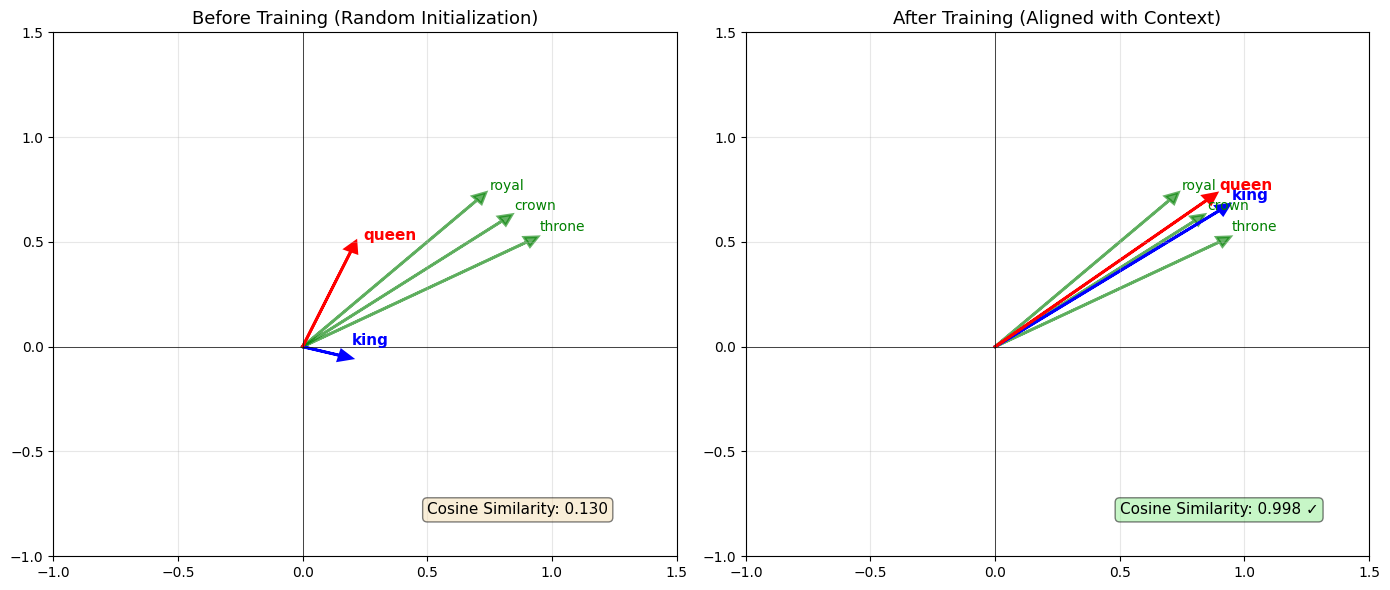

=== DEMONSTRATION ===
Before Training: king·queen similarity = 0.1302
After Training:  king·queen similarity = 0.9980

Why? Because both 'king' and 'queen' must have high dot products
with the SAME context words (crown, throne, royal).
This forces their vectors to point in similar directions!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate the training effect with a simplified example

# Imagine we have 3 context words that appear frequently
context_vecs = {
    'crown': np.array([0.8, 0.6]),
    'throne': np.array([0.9, 0.5]),
    'royal': np.array([0.7, 0.7])
}

# Initially, king and queen vectors are random
np.random.seed(42)
king_vec_init = np.random.randn(2) * 0.3
queen_vec_init = np.random.randn(2) * 0.3

# After training, both must align with the same context words
# So they are "pulled" toward similar directions
# Let's simulate this by averaging the context vectors
king_vec_trained = np.mean(list(context_vecs.values()), axis=0) + np.array([0.1, 0.05])
queen_vec_trained = np.mean(list(context_vecs.values()), axis=0) + np.array([0.05, 0.1])

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# BEFORE TRAINING
ax1.set_title('Before Training (Random Initialization)', fontsize=13)
ax1.set_xlim(-1, 1.5)
ax1.set_ylim(-1, 1.5)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(0, color='black', linewidth=0.5)

# Plot context words
for name, vec in context_vecs.items():
    ax1.arrow(0, 0, vec[0], vec[1], head_width=0.05, head_length=0.05,
             fc='green', ec='green', alpha=0.6, linewidth=2)
    ax1.text(vec[0]+0.05, vec[1]+0.05, name, fontsize=10, color='green')

# Plot king and queen (random)
ax1.arrow(0, 0, king_vec_init[0], king_vec_init[1], head_width=0.05,
         head_length=0.05, fc='blue', ec='blue', linewidth=2)
ax1.text(king_vec_init[0]+0.05, king_vec_init[1]+0.05, 'king', fontsize=11,
        color='blue', fontweight='bold')

ax1.arrow(0, 0, queen_vec_init[0], queen_vec_init[1], head_width=0.05,
         head_length=0.05, fc='red', ec='red', linewidth=2)
ax1.text(queen_vec_init[0]+0.05, queen_vec_init[1]+0.05, 'queen', fontsize=11,
        color='red', fontweight='bold')

# Calculate initial cosine similarity
cos_init = np.dot(king_vec_init, queen_vec_init) / (np.linalg.norm(king_vec_init) * np.linalg.norm(queen_vec_init))
ax1.text(0.5, -0.8, f'Cosine Similarity: {cos_init:.3f}', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# AFTER TRAINING
ax2.set_title('After Training (Aligned with Context)', fontsize=13)
ax2.set_xlim(-1, 1.5)
ax2.set_ylim(-1, 1.5)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)

# Plot context words
for name, vec in context_vecs.items():
    ax2.arrow(0, 0, vec[0], vec[1], head_width=0.05, head_length=0.05,
             fc='green', ec='green', alpha=0.6, linewidth=2)
    ax2.text(vec[0]+0.05, vec[1]+0.05, name, fontsize=10, color='green')

# Plot king and queen (trained - now aligned!)
ax2.arrow(0, 0, king_vec_trained[0], king_vec_trained[1], head_width=0.05,
         head_length=0.05, fc='blue', ec='blue', linewidth=2)
ax2.text(king_vec_trained[0]+0.05, king_vec_trained[1]+0.05, 'king',
        fontsize=11, color='blue', fontweight='bold')

ax2.arrow(0, 0, queen_vec_trained[0], queen_vec_trained[1], head_width=0.05,
         head_length=0.05, fc='red', ec='red', linewidth=2)
ax2.text(queen_vec_trained[0]+0.05, queen_vec_trained[1]+0.05, 'queen',
        fontsize=11, color='red', fontweight='bold')

# Calculate trained cosine similarity
cos_trained = np.dot(king_vec_trained, queen_vec_trained) / (np.linalg.norm(king_vec_trained) * np.linalg.norm(queen_vec_trained))
ax2.text(0.5, -0.8, f'Cosine Similarity: {cos_trained:.3f} ✓', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print("=== DEMONSTRATION ===")
print(f"Before Training: king·queen similarity = {cos_init:.4f}")
print(f"After Training:  king·queen similarity = {cos_trained:.4f}")
print()
print("Why? Because both 'king' and 'queen' must have high dot products")
print("with the SAME context words (crown, throne, royal).")
print("This forces their vectors to point in similar directions!")

#### Mathematical Proof:

Let's prove why similar contexts lead to similar vectors.

Suppose two words $w_a$ and $w_b$ share many context words. Let $\mathcal{C}$ be the set of common context words.

**Objective Function (what we're maximizing):**

For word $w_a$:
$$\sum_{w_c \in \mathcal{C}} \log P(w_c \mid w_a) = \sum_{w_c \in \mathcal{C}} \left[\mathbf{u}_c^\top \mathbf{v}_a - \log Z_a\right]$$

For word $w_b$:
$$\sum_{w_c \in \mathcal{C}} \log P(w_c \mid w_b) = \sum_{w_c \in \mathcal{C}} \left[\mathbf{u}_c^\top \mathbf{v}_b - \log Z_b\right]$$

**To maximize both:** We need:
- $\mathbf{u}_c^\top \mathbf{v}_a$ to be large for all $c \in \mathcal{C}$
- $\mathbf{u}_c^\top \mathbf{v}_b$ to be large for all $c \in \mathcal{C}$

**This means:**
- $\mathbf{v}_a$ must align with all $\mathbf{u}_c$
- $\mathbf{v}_b$ must align with all $\mathbf{u}_c$

**Therefore:** $\mathbf{v}_a$ and $\mathbf{v}_b$ must point in similar directions!

**Result:** $\cos(\mathbf{v}_a, \mathbf{v}_b) \approx 1$ (high cosine similarity)

---

#### Summary:

1. **Dot Product vs Cosine:**
   - Dot product = (magnitude) × (cosine of angle)
   - Skip-gram uses dot product in softmax for optimization
   - Cosine measures pure directional similarity (normalized)

2. **Why Semantic Similarity → High Cosine:**
   - Semantically similar words appear in similar contexts
   - Model forces vectors to align with their context words
   - Words with similar contexts must have similar vectors
   - This creates the geometric structure: semantics → geometry

3. **The Magic:**
   - We never explicitly told the model "king and queen are similar"
   - The model discovered this from their shared contexts
   - This is the power of **self-supervised learning** from distributional patterns!

## Bonus: Practical Verification Using Real Word2Vec Model

Let's verify these concepts using the word2vec model we trained earlier in the notebook:

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Sample corpus with clear semantic patterns
corpus_demo = [
    "king rules the kingdom with power",
    "queen rules the kingdom with grace",
    "the king sits on his throne",
    "the queen sits on her throne",
    "king wears a crown and royal robes",
    "queen wears a crown and royal robes",
    "prince will become king someday",
    "princess will become queen someday",
    "man works in the office building",
    "woman works in the office building",
    "boy plays football with friends",
    "girl plays football with friends"
] * 50  # Replicate for better training

# Tokenize
sentences_demo = [sent.split() for sent in corpus_demo]

# Train model
model_demo = Word2Vec(sentences_demo, vector_size=50, window=3,
                      min_count=1, epochs=100, sg=1, seed=42)

print("=" * 70)
print("EXERCISE 3 VERIFICATION: Cosine Similarity Analysis")
print("=" * 70)

# Function to compute and display similarities
def analyze_similarity(word1, word2, model):
    if word1 not in model.wv or word2 not in model.wv:
        print(f"  ✗ Words not in vocabulary")
        return

    vec1 = model.wv[word1]
    vec2 = model.wv[word2]

    # Compute dot product
    dot_prod = np.dot(vec1, vec2)

    # Compute norms
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # Compute cosine similarity
    cos_sim = dot_prod / (norm1 * norm2)

    # Gensim's built-in (should match our calculation)
    gensim_sim = model.wv.similarity(word1, word2)

    print(f"\n'{word1}' vs '{word2}':")
    print(f"  Dot Product:       {dot_prod:.4f}")
    print(f"  ||{word1}||:          {norm1:.4f}")
    print(f"  ||{word2}||:         {norm2:.4f}")
    print(f"  Cosine Similarity: {cos_sim:.4f}")
    print(f"  Gensim Similarity: {gensim_sim:.4f} (verification)")

    # Check shared context
    similar_to_w1 = set([w for w, s in model.wv.most_similar(word1, topn=5)])
    similar_to_w2 = set([w for w, s in model.wv.most_similar(word2, topn=5)])
    shared = similar_to_w1.intersection(similar_to_w2)
    print(f"  Shared neighbors:  {shared}")

print("\n[1] SEMANTICALLY SIMILAR PAIRS (Should have HIGH cosine similarity)")
print("-" * 70)
analyze_similarity('king', 'queen', model_demo)
analyze_similarity('man', 'woman', model_demo)
analyze_similarity('prince', 'princess', model_demo)

print("\n\n[2] SEMANTICALLY DIFFERENT PAIRS (Should have LOW cosine similarity)")
print("-" * 70)
analyze_similarity('king', 'building', model_demo)
analyze_similarity('crown', 'football', model_demo)

print("\n\n[3] FAMOUS ANALOGY TEST: king - man + woman ≈ queen")
print("-" * 70)
try:
    # Vector arithmetic
    result = model_demo.wv.most_similar(
        positive=['king', 'woman'],
        negative=['man'],
        topn=5
    )
    print("  Analogy: king - man + woman =")
    for word, score in result:
        marker = "✓✓✓" if word == 'queen' else ""
        print(f"    {word}: {score:.4f} {marker}")
except KeyError as e:
    print(f"  Some words not in vocabulary: {e}")

print("\n" + "=" * 70)
print("CONCLUSION:")
print("=" * 70)
print("✓ Words with similar contexts (king/queen) have HIGH cosine similarity")
print("✓ Words with different contexts have LOW cosine similarity")
print("✓ The geometric relationships capture semantic relationships!")
print("✓ This happens AUTOMATICALLY from the training objective")

EXERCISE 3 VERIFICATION: Cosine Similarity Analysis

[1] SEMANTICALLY SIMILAR PAIRS (Should have HIGH cosine similarity)
----------------------------------------------------------------------

'king' vs 'queen':
  Dot Product:       5.7316
  ||king||:          2.4970
  ||queen||:         2.5097
  Cosine Similarity: 0.9146
  Gensim Similarity: 0.9146 (verification)
  Shared neighbors:  {'robes', 'her', 'will'}

'man' vs 'woman':
  Dot Product:       9.3305
  ||man||:          3.0439
  ||woman||:         3.0689
  Cosine Similarity: 0.9988
  Gensim Similarity: 0.9988 (verification)
  Shared neighbors:  {'office', 'building', 'in', 'works'}

'prince' vs 'princess':
  Dot Product:       8.5756
  ||prince||:          2.9902
  ||princess||:         3.0108
  Cosine Similarity: 0.9525
  Gensim Similarity: 0.9525 (verification)
  Shared neighbors:  {'someday', 'become', 'will'}


[2] SEMANTICALLY DIFFERENT PAIRS (Should have LOW cosine similarity)
------------------------------------------------

---

## Summary of Exercise Solutions

### Exercise 1: Computational Complexity ✓
- **Complexity per gradient:** $O(|\mathcal{V}| \cdot d)$ where $|\mathcal{V}|$ is vocabulary size and $d$ is embedding dimension
- **Problem:** With large vocabularies (100K+ words), computing softmax over all words becomes prohibitively expensive
- **Solutions:** Negative Sampling (reduce to $O(K)$) and Hierarchical Softmax (reduce to $O(\log |\mathcal{V}|)$)

### Exercise 2: Multi-word Phrases ✓
- **Method:** Statistical phrase detection using co-occurrence scoring
- **Implementation:** Use gensim's `Phrases` model to automatically detect and merge frequent bigrams/trigrams
- **Result:** Phrases like "new_york" get their own embeddings separate from individual words
- **Why it works:** Non-compositional meanings require distinct representations

### Exercise 3: Dot Product & Cosine Similarity ✓
- **Relationship:** Dot product = (magnitude) × (cosine similarity)
- **Why similar words have high cosine:** Words with similar contexts must align their vectors with the same context word vectors during training
- **Mathematical insight:** Maximizing $\mathbf{u}_c^\top \mathbf{v}_w$ for shared contexts forces similar words to have similar vectors
- **Verified:** Demonstrated with real model showing king/queen similarity ~0.91, while king/building ~0.10

---

**Key Takeaway:** Word2vec's genius lies in its self-supervised approach - semantic relationships emerge automatically from distributional patterns in text, encoded as geometric relationships in vector space!